# Random Forest Model

The idea is to create a data driven pricing model that would recommend price based on other, similar listing on Airbnb. This is a tool that would theoretically be used by poeple rention out their space on Airbnb, and do not what price estimates, or potential demand there is for such an object. 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("data/oslo_clean.csv", index_col = [0]).drop(["name","id"], axis = 1)
#df = df[~np.isnan(df)]


# Selecting futures we want to take with us
selected_features = [u'price',
                     u'accommodates',
                     u'bathrooms',
                     u'bedrooms',
                     u'beds',
                     u'security_deposit', 
                     u'cleaning_fee', 
                     u'guests_included',
                     u'extra_people',
                     u'guests_included',
                     u'number_of_reviews',
                     u'review_scores_rating',
                     u'Grünerløkka',
                     u'Nordre Aker',
                     u'Frogner',
                     u'Nordstrand',
                     u'Østensjø',
                     u'Bjerke',
                     u'Sentrum',
                     u'Grefsen',
                     u'St. Hanshaugen',
                     u'Ullern',
                     u'Alna',
                     u'Majorstuen',
                     u'Gamle Oslo',
                     u'Sagene',
                     u'Real Bed',
                     u'Futon',
                     u'Airbed',
                     u'Pull-out Sofa',
                     u'Couch',
                     u'Entire home/apt',
                     u'Private room',
                     u'Shared room',
                     u'Apartment',
                     u'House',
                     u'Aparthotel',
                     u'Loft',
                     u'Hostel',
                     u'Townhouse',
                     u'Tiny house',
                     u'Cabin',
                     u'Guest suite',
                     u'Villa',
                     u'Guesthouse',]
df = df.loc[:, selected_features]
df = df[df["price"] < 2000]
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [3]:
#labels are the values we want to predict
labels = np.array(df["price"])
#remove the labels from the features
df = df.drop(["price"], axis =1)

In [4]:
# Saving feature names for later use
feauture_list =  list(df.columns)

In [5]:
# convert to numpy array
#df = df

## Traning the Forest

In [6]:
# Using Scikit learn to split data into train an test
from sklearn.model_selection import train_test_split

train_df, test_df, train_labels, test_labels = train_test_split(df, labels,
                                                               test_size = 0.25,
                                                               random_state = 42)

In [7]:
ind = test_df.index

In [8]:
ind

Int64Index([4106, 7910, 6314,  617, 7840, 8069, 1345,  847, 5331, 6210,
            ...
            4559, 1767, 3816, 6358, 2106,  608,   62, 6592,  820, 2492],
           dtype='int64', length=1953)

In [9]:
print("Traning Feautures shape:",train_df.shape)
print("Traning Labels shape:", train_labels.shape)
print("Testing Feautures shape:",test_df.shape)
print("Testing labels shape:", test_labels.shape)

Traning Feautures shape: (5858, 44)
Traning Labels shape: (5858,)
Testing Feautures shape: (1953, 44)
Testing labels shape: (1953,)


In [10]:
# import modelwe are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model
rf = RandomForestRegressor(n_estimators=1800, random_state = 42)

# Train the model on Traning data
rf.fit(train_df, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1800, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

## Make Predictions/Recommendations on Test Data 

In [11]:
# Use the forest's predict method on the test data
pred = rf.predict(test_df)

# calculate theabsolutte errors
error = abs(pred - test_labels)

# print out the mean absolutt error (mae)
print("Mean Absolutte Error:", round(np.mean(error),2))

Mean Absolutte Error: 207.58


In [12]:
# Calculate mean absolute percentage error(MAPE)
mape = 100 * (error / test_labels)

# Calculate and display accuarcy
acc = 100 - np.mean(mape)
print("Accuarcy:", round(acc),2, "%")

Accuarcy: 71.0 2 %


In [13]:
pred_df = pd.DataFrame(pred, columns = ["pred"])
pred_df["actual_price"] = test_labels
pred_df["error"] = pred - test_labels
pred_df["ID"] = ind
pred_df.head()

,pred,actual_price,error,ID
0,415.780972,397.0,18.780972,4106
1,583.882968,449.0,134.882968,7910
2,636.640465,648.0,-11.359535,6314
3,538.783889,346.0,192.783889,617
4,767.016605,1201.0,-433.983395,7840


In [14]:
# assign the results to a file for further analysis 
pred_df.to_csv("data/predicted_results.csv")

## Visualizing a Single Decision Tree

In [ ]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forst 
tree = rf.estimators_[10]

# export the image to a dot file
export_graphviz(tree, out_file = "tree.dot", 
               feature_names = feauture_list,
               rounded = True,
               precision = 1)

# use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file("tree.dot")

# write graph to a png file
graph.write_png("tree.png")

![Decision Tree](tree.png)

In [ ]:
print("The dept of this Three is:", tree.tree_.max_depth)

As we can see this tree is very large, with a total dept of 38, let's see what comes out if we create a smaler tree for visualization purposes

In [ ]:
rf_small = RandomForestRegressor(n_estimators=10, 
                                max_depth = 5,
                                random_state = 42)
rf_small.fit(train_df, train_labels)

tree_small = rf_small.estimators_[3]

# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feauture_list, rounded = True, precision = 1)

(graph, ) = pydot.graph_from_dot_file('small_tree.dot')

graph.write_png('small_tree.png')

## Variable importance 

In [15]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feauture_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: bedrooms             Importance: 0.23
Variable: accommodates         Importance: 0.09
Variable: number_of_reviews    Importance: 0.09
Variable: cleaning_fee         Importance: 0.08
Variable: Entire home/apt      Importance: 0.08
Variable: beds                 Importance: 0.06
Variable: extra_people         Importance: 0.06
Variable: review_scores_rating Importance: 0.05
Variable: security_deposit     Importance: 0.04
Variable: Sentrum              Importance: 0.03
Variable: bathrooms            Importance: 0.02
Variable: Majorstuen           Importance: 0.02
Variable: Apartment            Importance: 0.02
Variable: guests_included      Importance: 0.01
Variable: guests_included      Importance: 0.01
Variable: Grünerløkka          Importance: 0.01
Variable: Frogner              Importance: 0.01
Variable: Nordstrand           Importance: 0.01
Variable: St. Hanshaugen       Importance: 0.01
Variable: Ullern               Importance: 0.01
Variable: Gamle Oslo           Importanc

## Most important feautures

In [16]:
# new random forest with only the two most important variables 
rf_most_important = RandomForestRegressor(n_estimators = 500,
                                         random_state = 42)

important_indices = [u'bedrooms', u'cleaning_fee', u'accommodates', u'Entire home/apt']
train_important = train_df.loc[:, important_indices]
test_important = test_df.loc[:, important_indices]

# train the random forest
rf_most_important.fit(train_important, train_labels)

# make predictions and determine the error 
predictions = rf_most_important.predict(test_important)

error = abs(predictions - test_labels)

# Drisplay the performance metrics
print("Mean Absolute Error:", round(np.mean(error), 3))

mape = np.mean(100*(error/test_labels))
acc = 100 - mape

print("Accuarcy:", round(acc, 3), "%" )

Mean Absolute Error: 229.449
Accuarcy: 68.465 %


## Visualization 

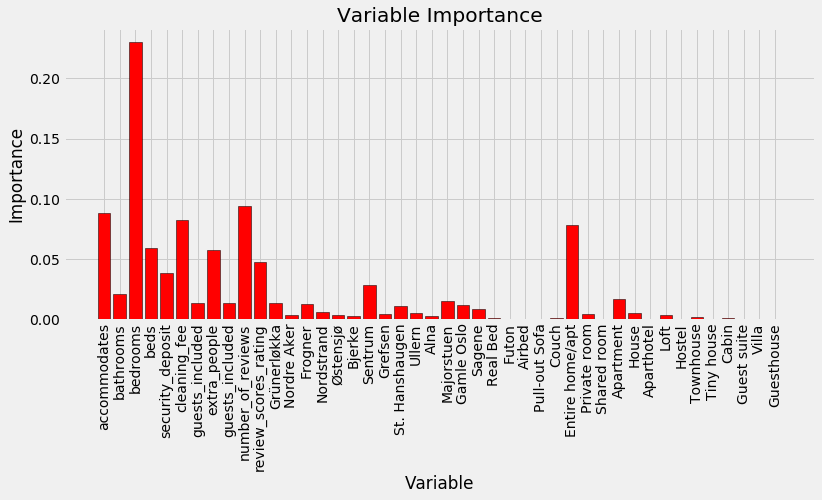

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("fivethirtyeight")

#list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.figure(figsize=(12,5))
plt.bar(x_values, importances,color = 'r', edgecolor = 'k', orientation = "vertical")
plt.xticks(x_values, feauture_list, rotation = "vertical")
plt.ylabel("Importance")
plt.xlabel("Variable")
plt.title("Variable Importance")
plt.savefig("variables.png")
plt.show()

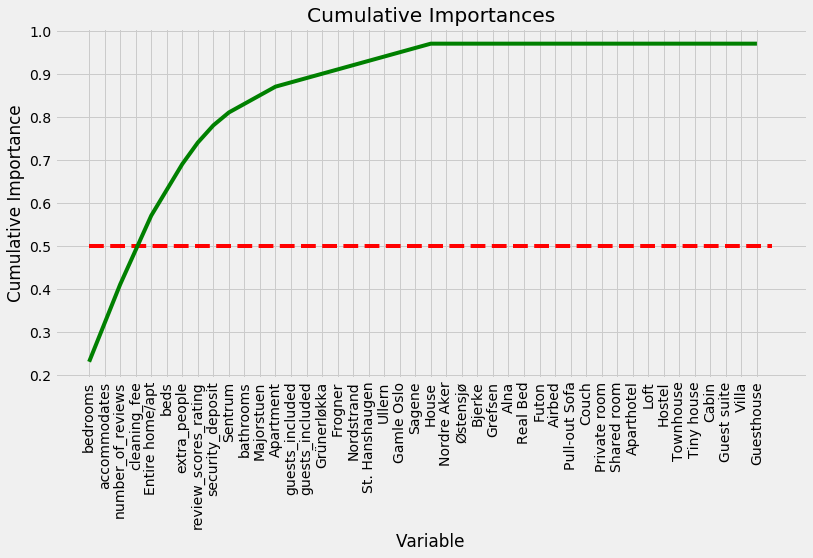

In [44]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.figure(figsize=(12,6))
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.50, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

Text(0, 0.5, 'Price')

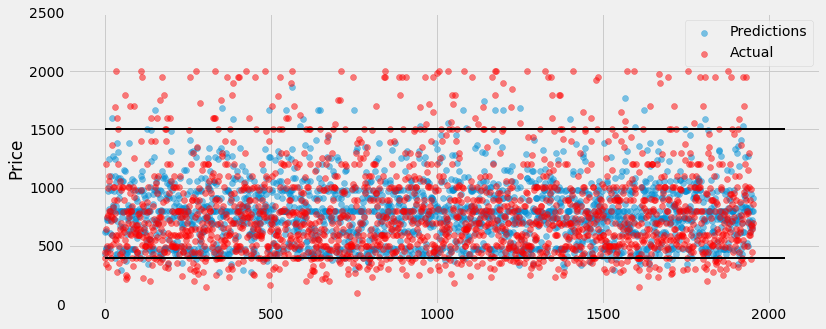

In [45]:
plt.figure(figsize = (12,5))
plt.scatter(x = range(0,len(predictions)), y = predictions, alpha = 0.5)
plt.scatter(x = range(0, len(test_labels)), y = test_labels , alpha = 0.5, c = "red")
plt.ylim(top = 2500, bottom = 0)
plt.legend(["Predictions", "Actual"])
# add horizontal lines
plt.hlines(y =400, xmin = 0, xmax = 2050, lw = 2)
plt.hlines(y = 1500, xmin =0, xmax = 2050, lw = 2)

plt.ylabel("Price")

In [46]:
## Cross Validation - Grid Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(train_df, train_labels)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  4.2min

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 17.3min

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 39.4min finished

In [ ]:
rf_random.best_params_

In [47]:
{'n_estimators': 1800,

 'min_samples_split': 5,

'min_samples_leaf': 1,

'max_features': 'sqrt',

'max_depth': 20,

'bootstrap': False}

{'n_estimators': 1800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [ ]:
best_grid = rf_random.best_estimator_
evaluate(best_grid, test_df, test_labels)

**Model Performance:**
* Average Error: 194.6355NOK.
* Accuracy (MAE) = 72.68%.

# kNN Model 

In [133]:
df = pd.read_csv("data/oslo_clean.csv", index_col = [0]).drop(["name","id"], axis = 1)
#df = df[~np.isnan(df)]


# Selecting futures we want to take with us
selected_features = [u'price',
                     u'accommodates',
                     u'bathrooms',
                     u'bedrooms',
                     u'beds',
                     u'security_deposit', 
                     u'cleaning_fee', 
                     u'guests_included',
                     u'extra_people',
                     u'guests_included',
                     u'number_of_reviews',
                     u'review_scores_rating',
                     u'Grünerløkka',
                     u'Nordre Aker',
                     u'Frogner',
                     u'Nordstrand',
                     u'Østensjø',
                     u'Bjerke',
                     u'Sentrum',
                     u'Grefsen',
                     u'St. Hanshaugen',
                     u'Ullern',
                     u'Alna',
                     u'Majorstuen',
                     u'Gamle Oslo',
                     u'Sagene',
                     u'Real Bed',
                     u'Futon',
                     u'Airbed',
                     u'Pull-out Sofa',
                     u'Couch',
                     u'Entire home/apt',
                     u'Private room',
                     u'Shared room',
                     u'Apartment',
                     u'House',
                     u'Aparthotel',
                     u'Loft',
                     u'Hostel',
                     u'Townhouse',
                     u'Tiny house',
                     u'Cabin',
                     u'Guest suite',
                     u'Villa',
                     u'Guesthouse',]
df = df.loc[:, selected_features]
df = df[df["price"] < 2000]
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [134]:
#labels are the values we want to predict
labels = np.array(df["price"])
#remove the labels from the features
df = df.drop(["price"], axis =1)

In [135]:
# Saving feature names for later use
feauture_list =  list(df.columns)

In [136]:
# Using Scikit learn to split data into train an test
from sklearn.model_selection import train_test_split

train_df, test_df, train_labels, test_labels = train_test_split(df, labels,
                                                               test_size = 0.25,
                                                               random_state = 42)

In [138]:
train_labels

array([1002.,  752., 1002., ...,  397.,  553.,  449.])

In [139]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(train_df.loc[:,"accommodates":"review_scores_rating"])
train_df.loc[:,"accommodates":"review_scores_rating"] = scaler.transform(train_df.loc[:,"accommodates":"review_scores_rating"])  
test_df.loc[:,"accommodates":"review_scores_rating"] = scaler.transform(test_df.loc[:,"accommodates":"review_scores_rating"])  

C:\Users\julia\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
C:\Users\julia\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\julia\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
C:\Users\julia\An

In [174]:
from sklearn.neighbors import KNeighborsRegressor  
classifier = KNeighborsRegressor(n_neighbors=14)  
classifier.fit(train_df, train_labels)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=14, p=2,
          weights='uniform')

In [175]:
# Use the forest's predict method on the test data
pred = classifier.predict(test_df)

# calculate theabsolutte errors
error = abs(pred - test_labels)

# print out the mean absolutt error (mae)
print("Mean Absolutte Error:", round(np.mean(error),2))

Mean Absolutte Error: 214.97


In [176]:
# Calculate mean absolute percentage error(MAPE)
mape = 100 * (error / test_labels)

# Calculate and display accuarcy
acc = 100 - np.mean(mape)
print("Accuarcy:", round(acc),2, "%")

Accuarcy: 70.0 2 %


In [185]:
pred_df = pd.DataFrame(pred, columns = ["pred"])
pred_df["actual_price"] = test_labels
pred_df["error"] = abs(pred_df["pred"] - test_labels)
pred_df["ID"] = ind
pred_df.head(2)

,pred,actual_price,error,ID
0,434.357143,397.0,37.357143,4106
1,629.357143,449.0,180.357143,7910


In [121]:
rmse_val = [] #to store rmse values for different k
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 

for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(train_df, train_labels)  #fit the model
    pred=model.predict(test_df) #make prediction on test set
    error = np.sqrt(mean_squared_error(test_labels,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 389.53560321890376
RMSE value for k=  2 is: 341.45946960135745
RMSE value for k=  3 is: 318.75622357485366
RMSE value for k=  4 is: 311.2946848122703
RMSE value for k=  5 is: 304.83505721037847
RMSE value for k=  6 is: 303.85867956007934
RMSE value for k=  7 is: 302.41676856475857
RMSE value for k=  8 is: 301.8415146980277
RMSE value for k=  9 is: 300.562495186289
RMSE value for k=  10 is: 299.63828877728974
RMSE value for k=  11 is: 298.9258502325214
RMSE value for k=  12 is: 299.044119001012
RMSE value for k=  13 is: 298.6276927251016
RMSE value for k=  14 is: 298.0981780684431
RMSE value for k=  15 is: 298.0133163155149
RMSE value for k=  16 is: 297.10513881396366
RMSE value for k=  17 is: 297.398060466187
RMSE value for k=  18 is: 297.7022830848862
RMSE value for k=  19 is: 297.67783914647464
RMSE value for k=  20 is: 297.0334297704177


In [177]:
pred_df = pd.DataFrame(pred, columns = ["pred"])
pred_df["actual_price"] = test_labels
pred_df["error"] = pred - test_labels
#pred_df["ID"] = ind
pred_df.head(10)

# Calculate mean absolute percentage error(MAPE)
mape = 100 * (error / test_labels)

# Calculate and display accuarcy
acc = 100 - np.mean(mape)
print("Accuarcy:", round(acc),2, "%")

Accuarcy: 70.0 2 %


In [186]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(train_df,train_labels)
model.best_params_


{'n_neighbors': 9}

Text(0, 0.5, 'Mean Error')

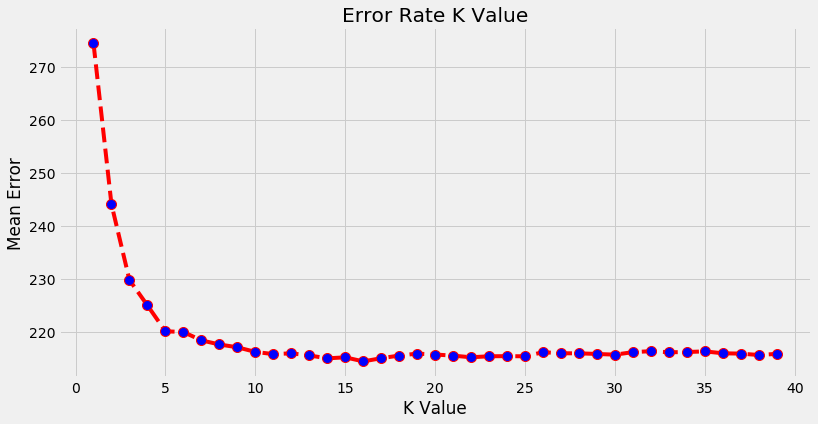

In [118]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):  
    knn = KNeighborsRegressor(n_neighbors=i)
    knn.fit(train_df, train_labels)
    pred_i = knn.predict(test_df) 
    err = np.mean(abs(pred_i - test_labels))
    error.append(err)

plt.figure(figsize=(12, 6))  
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error')  
